In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
from tqdm import tqdm_notebook
from scipy.io import wavfile
from copy import deepcopy

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

In [4]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [5]:
train_data.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [44]:
test_data.head()

,fname,label,usage,freesound_id,license
0,00326aa9.wav,Oboe,Private,355125,Attribution
1,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0
2,007759c4.wav,Saxophone,Private,13406,Creative Commons 0
3,008afd93.wav,Saxophone,Private,358962,Attribution
4,00ae03f6.wav,Chime,Private,78203,Attribution


In [6]:
classes = np.unique(train_data['label'])
n_classes = len(classes)

num_to_label = dict([[v,k] for v,k in enumerate(classes)])
label_to_num = dict([[k,v] for v,k in enumerate(classes)])

In [7]:
data_manual = train_data[train_data['manually_verified']==1]
data_auto = train_data[train_data['manually_verified']==0]

In [45]:
filenames_all = train_data['fname'].tolist()
labels_all = [label_to_num[f] for f in train_data['label']]

filenames_manual = data_manual['fname'].tolist()
labels_manual = [label_to_num[f] for f in data_manual['label']]

filenames_auto = data_auto['fname'].tolist()
labels_auto = [label_to_num[f] for f in data_auto['label']]

filenames_test = test_data['fname'].tolist()
labels_test = [label_to_num[f] for f in test_data['label']]

In [9]:
sr = 16000
file_length = sr*4
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

In [10]:
def load_data_mel(filenames,path,n_mels,sr,seconds):
    
    min_length = sr*seconds
    
    specs = []
    
    for i,file in enumerate(tqdm_notebook(filenames)):
        
        wave,_ = librosa.load(os.path.join(path,file),sr=sr,dtype = np.float32) 
        wave,_ = librosa.effects.trim(wave)
        if len(wave)<=min_length:
            
            amount = min_length-len(wave)
            wave = np.pad(wave,(int(np.ceil(amount/2)),int(np.floor(amount/2))),'constant')
            
        wave = wave/np.max(np.absolute(wave+1e-10))
        
        spect = librosa.feature.melspectrogram(wave,sr=sr,n_mels=n_mels)
        spect = librosa.amplitude_to_db(spect)
        
        mean = np.mean(spect)
        std = np.std(spect)
        if std == 0:
            std+=1e-10
        spect = (spect-mean)/(std)
        
        specs.append(spect)
    
    return specs

In [55]:
import pickle

In [63]:
with open('train_mel80_512','wb')as fp:
    pickle.dump(X_all,fp)

In [57]:
with open('outfile','rb') as fp:
    X_test2 = pickle.load(fp)

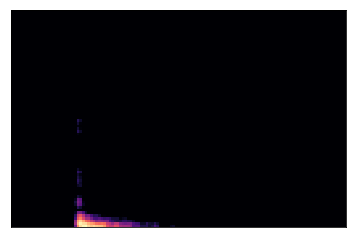

In [60]:
librosa.display.specshow(X_test[1])

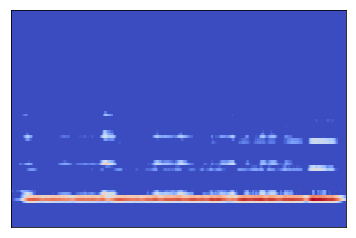

In [62]:
librosa.display.specshow(X_test2[2])

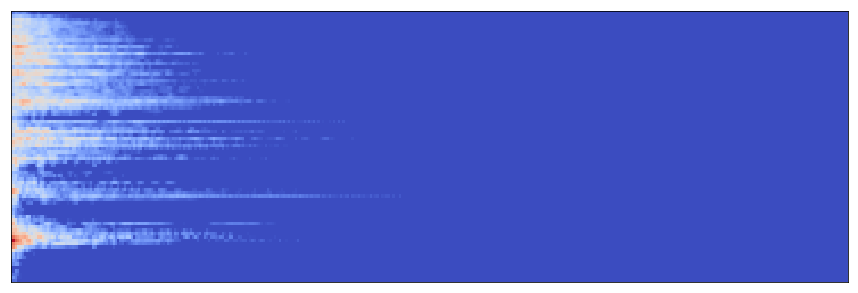

In [53]:
plt.figure(figsize = (15,5))
librosa.display.specshow(X_all[0])

In [11]:
X_all = load_data_mel(filenames_all,path_train,n_mels,sr,4)

In [46]:
X_test = load_data_mel(filenames_test,path_test,n_mels,sr,4)

In [18]:
#X_curated = load_data_mel(filenames_manual,path_train,n_mels,sr,44100)

In [19]:
#X_noisy = load_data_mel(filenames_auto,path_train,n_mels,sr,44100)

In [22]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self,x_set,y_set,
                 batch_size = 128,input_shape = (80,frames),
                 n_classes=80, sr = 44100, seconds = 4):
        
        self.x, self.y = x_set,y_set
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.sr = sr
        self.file_length = sr*seconds
        #self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.x)/self.batch_size))
    
    def __getitem__(self,idx):
        
        spects = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = self.__generate_data(spects)
        
        #print(batch_x.shape)
        #print(batch_y.shape)
        
        return batch_x,batch_y
    
    def __generate_data(self,spects):
        n_mels,frames = self.input_shape
        x_batch = np.zeros((len(spects),n_mels,frames))
        
        for i, spect in enumerate(spects):
            freq_res,time_res = spect.shape
            
            max_start = time_res-frames
            if max_start == 0:
                start = 0
            else:
                start = np.random.randint(0,max_start)
            end = start+frames
            
            x_batch[i] = spect[:,start:end]
        
        return x_batch

# Malley CNN

In [23]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Activation
from keras.layers import GlobalMaxPool2D, Dense, Input
from keras.layers import Lambda
from keras.models import Model
from keras.activations import relu, softmax
from keras.backend import expand_dims
from keras.optimizers import Adam
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

In [24]:
def malley_cnn_80(input_shape, n_classes):

    X_input = Input(input_shape)
    
    X = Lambda(lambda q: expand_dims(q, -1), name='expand_dims') (X_input)
    
    X = Conv2D(64,[3,7],padding = 'same')(X)
    X = Activation(relu)(X)
    X = MaxPool2D([2,1])(X)
    
    X = Conv2D(128,[7,1],padding = 'same')(X)
    X = Activation('relu')(X)
    X = MaxPool2D([4,1])(X)
    
    X = Conv2D(256,[10,1],padding = 'valid')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(512,[1,7],padding = 'same')(X)
    X = Activation('relu')(X)
    
    X = GlobalMaxPool2D()(X)
    
    X = Dense(512,activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(n_classes, activation = 'softmax')(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [25]:
input_shape = ([n_mels,frames])
lr = 0.001
malley = malley_cnn_80(input_shape,n_classes)
malley.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 125)           0         
_________________________________________________________________
expand_dims (Lambda)         (None, 80, 125, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 125, 64)       1408      
_________________________________________________________________
activation_1 (Activation)    (None, 80, 125, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 125, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 125, 128)      57472     
_________________________________________________________________
activation_2 (Activation)    (None, 40, 125, 128)      0         
__________

In [26]:
malley.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

### Split Dataset and make Generators

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
#X_train_n,X_val_n,y_train_n,y_val_n = train_test_split(X_noisy,y_noisy,test_size=0.1, random_state=7)

In [30]:
X_train_a,X_val_a,y_train_a,y_val_a = train_test_split(X_all,labels_all,test_size=0.1, random_state=7)

In [31]:
#train_generator_n = DataGenerator(X_train_n,y_train_n)
#val_generator_n = DataGenerator(X_val_n,y_val_n)

In [33]:
train_generator_a = DataGenerator(X_train_a,y_train_a)
val_generator_a = DataGenerator(X_val_a,y_val_a)

### Train the Model

In [34]:
malley.fit_generator(train_generator_a,epochs = 50,validation_data=val_generator_a)

Epoch 1/50
67/67 [==============================] - 15s 230ms/step - loss: 2.8815 - acc: 0.2081 - val_loss: 2.2105 - val_acc: 0.3692
Epoch 2/50
67/67 [==============================] - 13s 195ms/step - loss: 2.0660 - acc: 0.4053 - val_loss: 1.7815 - val_acc: 0.4958
Epoch 3/50
67/67 [==============================] - 13s 196ms/step - loss: 1.7415 - acc: 0.5054 - val_loss: 1.6523 - val_acc: 0.5316
Epoch 4/50
67/67 [==============================] - 13s 196ms/step - loss: 1.5110 - acc: 0.5692 - val_loss: 1.4415 - val_acc: 0.5992
Epoch 5/50
67/67 [==============================] - 13s 196ms/step - loss: 1.3517 - acc: 0.6127 - val_loss: 1.3109 - val_acc: 0.6392
Epoch 6/50
67/67 [==============================] - 13s 197ms/step - loss: 1.2017 - acc: 0.6571 - val_loss: 1.2558 - val_acc: 0.6530
Epoch 7/50
67/67 [==============================] - 14s 205ms/step - loss: 1.1059 - acc: 0.6820 - val_loss: 1.2310 - val_acc: 0.6551
Epoch 8/50
67/67 [==============================] - 13s 197ms/step - 

### Train Only with Curated Data

In [37]:
X_curated = []

for i,tag in enumerate(train_data['manually_verified']):
    if tag == 1:
        X_curated.append(X_all[i])

In [40]:
X_train_c,X_val_c,y_train_c,y_val_c = train_test_split(X_curated,labels_manual,test_size=0.1, random_state=7)

In [41]:
train_generator_c = DataGenerator(X_train_c,y_train_c)
val_generator_c = DataGenerator(X_val_c,y_val_c)

In [49]:
malley.fit_generator(train_generator_c,epochs = 1,validation_data=test_generator)

Epoch 1/1
27/27 [==============================] - 6s 222ms/step - loss: 0.0812 - acc: 0.9721 - val_loss: 1.4502 - val_acc: 0.7562


### Test